In [1]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from qunfold import QUnfolder, QPlotter
from qunfold.utils import normalize_response, lambda_optimizer


# Set random seed for replicability
seed = 42
np.random.seed(seed)


In [2]:
# Set parameters for synthetic data generation
entries = 20000
bins = 16
xmin, xmax = -3.5, 4.6
loc, scale = -2.0, 1.9
skewness = 3.6
mu_smear, std_smear = -0.08, 0.17
efficiency = 0.7  # same for all bins

In [3]:
# Generate Monte Carlo truth and reco data (with Gaussian smearing)
truth_mc_data = stats.skewnorm.rvs(skewness, loc=loc, scale=scale, size=entries)
smearing_mc = np.random.normal(mu_smear, std_smear, size=entries)
eff_mask_mc = np.random.rand(entries) < efficiency
reco_mc_data = (truth_mc_data + smearing_mc)[eff_mask_mc]

In [4]:
# Generate unknown truth and measured data (with Gaussian smearing)
truth_data = stats.skewnorm.rvs(skewness, loc=loc, scale=scale, size=entries)
smearing = np.random.normal(mu_smear, std_smear, size=entries)
eff_mask = np.random.rand(entries) < efficiency
measured_data = (truth_data + smearing)[eff_mask]

In [5]:
# Define histograms binning by adaptive KMeans algorithm
kbd = KBinsDiscretizer(bins, encode="ordinal", strategy="kmeans")
kbd.fit(np.clip(measured_data, xmin, xmax).reshape(-1, 1))
bin_edges = kbd.bin_edges_[0].tolist()
binning = np.array([-np.inf] + bin_edges + [np.inf])  # under/over-flow bins

In [6]:
# Build and normalize response matrix using Monte Carlo
response, _, _ = np.histogram2d(reco_mc_data, truth_mc_data[eff_mask_mc], bins=binning)
truth_mc, _ = np.histogram(truth_mc_data, bins=binning)
response = normalize_response(response, truth_mc=truth_mc)

In [7]:
# Define truth and measured histogram
truth, _ = np.histogram(truth_data, bins=binning)
measured, _ = np.histogram(measured_data, bins=binning)

In [8]:
# Find optimal value for regularization parameter lambda
#lam = lambda_optimizer(response=response, measured=measured, truth=truth_mc, binning=binning, num_reps=20, seed=seed)
lam=0.1

In [9]:
# Run QUnfold algorithm to solve unfolding problem
unfolder = QUnfolder(response=response, measured=measured, binning=binning, lam=lam)
unfolder.initialize_qubo_model()


In [10]:
num_reads=400
seed=seed
#total = client.map(unfolder.solve_simulated_annealing,[num_reads,800,1600,3200])
#total = client.submit(unfolder.solve_simulated_annealing,num_reads,5,3,seed)
sol,cov=unfolder.distributed_simulated_annealing(10000,seed=seed)

tra handel and gather


In [11]:
sol,cov

(array([   7,  255, 1246, 1949, 2335, 2474, 2432, 2199, 1903, 1586, 1184,
         864,  639,  460,  255,  111,   40,   10]),
 array([[   7,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   0,  255,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1246,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0, 1949,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0, 2335,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 2474,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0, 2432,    0,    0,    0,    0,
            0,    0,    0,    0,    0

In [ ]:
import dask
dask.__version__

In [12]:
plotter = QPlotter(
    response=response, measured=measured, truth=truth, unfolded=sol, covariance=cov, binning=binning, method="SA"
)

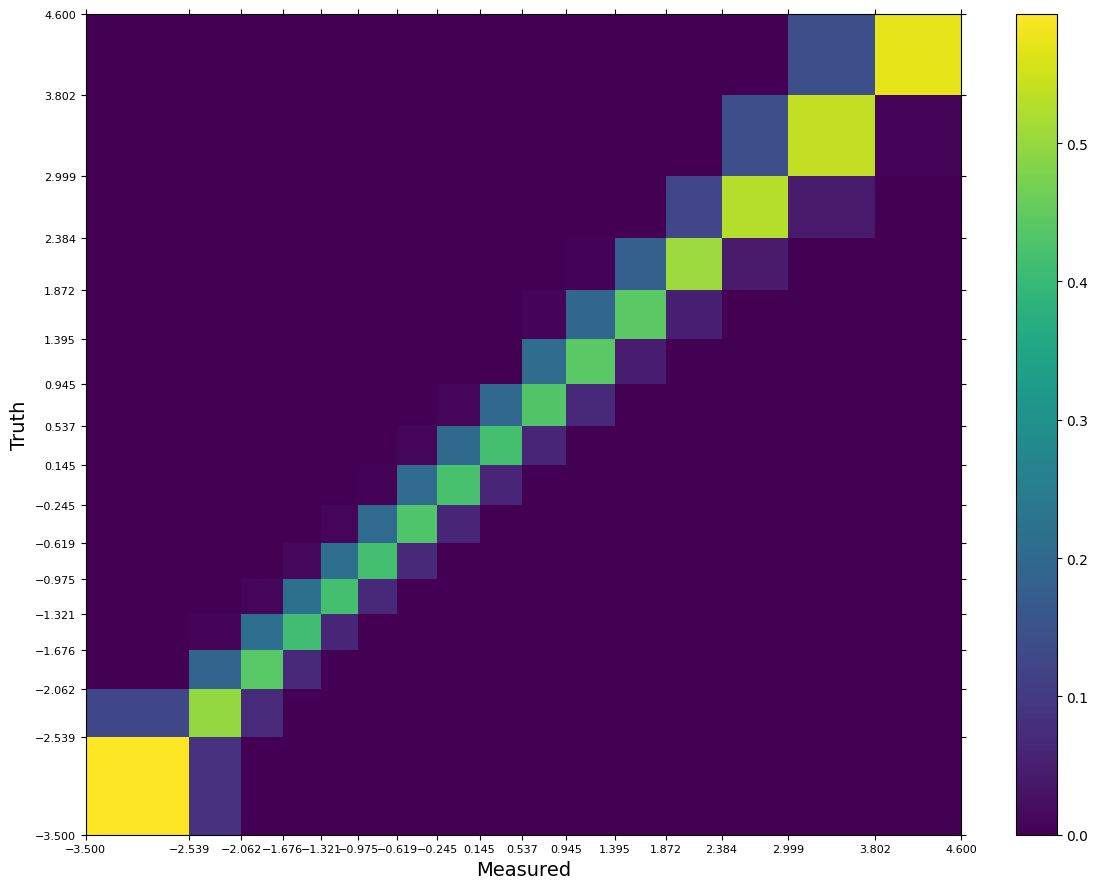

In [13]:
plotter.show_response()

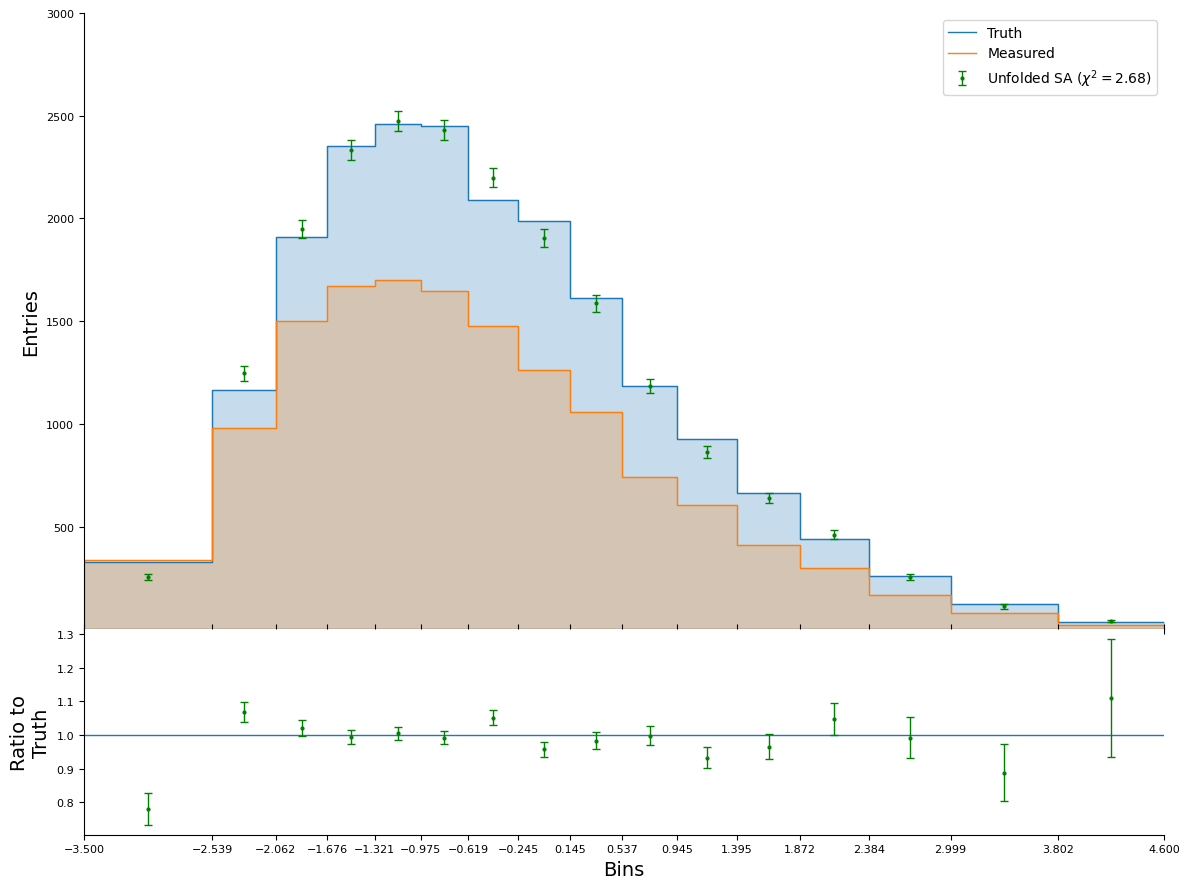

In [14]:
plotter.show_histograms()

In [11]:
cluster.close()
client.close()

NameError: name 'cluster' is not defined

2024-11-22 12:17:10,794 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
